# Random Forests

**Table of Contents**:
1. Introduction
    - 1.1 Prerequisites
2. Tuning Hyperparameters
    - 2.1 Strategy
    - 2.2 Tuning Number of Trees
    - 2.3. Optimisation using Random Grid Search with CV
3. Fitting the Random Forest
4. Conclusion
5. References

## 1. Introduction

Random forests are an ensemble of tree predictors where each tree is generated differently with a random perturbation. Each tree in the ensemble votes for the classification of a data point, and the majority class is the predicted class label. To improve accuracy, the random pertubations should be such that the correlation between the trees in the ensemble is minimised, while satisfying some other technical certain constraints (see [Section 3, 4]). Bagged trees are an example of a random forest, where the random pertubation is sampling with replacement from the training set. Random forests can introduce randomness in a variety of ways, such as randomly selecting splits from a number $K$ of the best splits at any node or randomly introducing noise in the outputs. These examples, and more, can be found in [2] and the references therein. We will only explore bagged trees which use a subset of features at each split here.

## 1.1 Prerequisites

We load the requirements and the data below.

In [2]:
### REQUIREMENTS ####

import subprocess
import sys

# List of required packages
required_packages = [
    'pandas',
    'matplotlib',
    'numpy',
    'scikit-learn',
    'tqdm',
    'seaborn',
]

# Function to check and install packages
def install(package):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

# Check and install required packages
for package in required_packages:
    try:
        __import__(package)
        print(f"'{package}' is already installed.")
    except ImportError:
        print(f"'{package}' not found. Installing...")
        install(package)

print("\nAll required packages are checked/installed.")

'pandas' is already installed.
'matplotlib' is already installed.
'numpy' is already installed.
'scikit-learn' not found. Installing...
'tqdm' is already installed.
'seaborn' is already installed.

All required packages are checked/installed.


In [3]:
#### IMPORTS #####

import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Data visualization
import numpy as np  # Numerical operations
import os  # Operating system functionalities
import pickle  # Storage of results
from sklearn.ensemble import RandomForestClassifier  # Random Forest model
from sklearn.impute import SimpleImputer  # For single imputation
from sklearn.model_selection import train_test_split  # Train-test split
from sklearn.model_selection import RandomizedSearchCV  # Randomized hyperparameter search
from sklearn.metrics import accuracy_score, classification_report  # Model evaluation metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc  # ROC AUC evaluation metrics
from tqdm import tqdm  # Progress bar
import seaborn as sns  # Statistical data visualization

In [4]:
# Load the saved datasets from the CSV files
X_train_smote = pd.read_csv("../data/X_train_smote.csv", index_col=0)
y_train_smote = pd.read_csv("../data/y_train_smote.csv", index_col=0)
X_test = pd.read_csv("../data/X_test.csv", index_col=0)
y_test = pd.read_csv("../data/y_test.csv", index_col=0)

# Assume original (non-SMOTE) training data is available as X_train and y_train
X_train_original = pd.read_csv("../data/X_train.csv", index_col=0)
y_train_original = pd.read_csv("../data/y_train.csv", index_col=0)

# Convert categorical columns to numeric codes
def encode_categorical(X):
    return X.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)

X_train_smote_encoded = encode_categorical(X_train_smote)
X_train_original_encoded = encode_categorical(X_train_original)
X_test_encoded = encode_categorical(X_test)

# 2. Tuning Hyperparameters

## 2.1 Strategy

This section will focus on tuning the random forest hyperparameters. There are many hyperparameters to tune, so we will perform a grid-based search using cross-validation. However, to simplify the search, we will first find an appropriate number of trees to use. This is because Breiman states in [2] that random trees do not overfit. In particular, as the number of trees gets large enough, the training error will stabilise. Hence, our strategy to tuning will be to first find an appropriate number of trees and then do a grid search for the others.

In a similar spirit to what we did with single trees, we will perform a **sensitivity analysis** to see how using SMOTE affects our conclusions, and whether it helps with imbalance or not. We will also explore another method for dealing with missingness. Before, we used 3 strategies for missing data: surrogate splits, treating missingness as its own category and doing complete case analysis. We take this opportunity to investigate imputations. **Imputation** simply refers to filling in a missing value. we will here do single imputations using the mode. 

## 2.2 Tuning Number of Trees

We explore the use of the out-of-bag (OOB) error. This is the error computed for each point, using only the trees which didn't "see" it in training. In other words, we only use the trees grown on bootstrapped samples which didn't use the point. Empirical evidence, given in [2], shows that the OOB estimate of the misclassification rate is "as accurate as using a test set of the same size as the training set". This justifies our use of OOB error. We do this below.

Loaded OOB errors from pickle file.
Best number of trees for SMOTE data: 300
Best number of trees for original data: 450


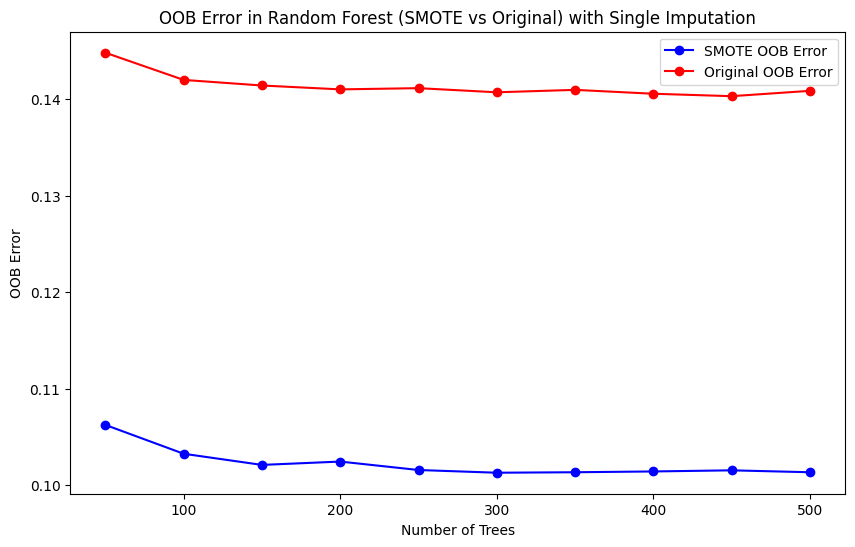

In [5]:
# Perform single imputation to handle missing data using SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# Impute the datasets
X_train_smote_imputed = pd.DataFrame(imputer.fit_transform(X_train_smote_encoded), columns=X_train_smote_encoded.columns)
X_train_original_imputed = pd.DataFrame(imputer.fit_transform(X_train_original_encoded), columns=X_train_original_encoded.columns)
X_test_imputed = pd.DataFrame(imputer.fit_transform(X_test_encoded), columns=X_test_encoded.columns)

# Range of n_estimators to try
n_estimators_range = range(50, 501, 50)

# Pickle file path to save/load OOB errors
pickle_file = "oob_errors_single_imputation.pkl"

# Function to fit Random Forest and collect OOB error
def calculate_oob_errors(X_train, y_train, n_estimators_range):
    oob_errors = []

    for n in tqdm(n_estimators_range, desc="Training models"):
        rf_model = RandomForestClassifier(n_estimators=n, random_state=42, oob_score=True)
        rf_model.fit(X_train, y_train.values.ravel())
        oob_errors.append(1 - rf_model.oob_score_)  # Calculate OOB error

    return oob_errors

# Check if the pickle file exists to avoid re-computation
if os.path.exists(pickle_file):
    # Load OOB errors from pickle file if it exists
    with open(pickle_file, "rb") as f:
        oob_errors_smote, oob_errors_original = pickle.load(f)
    print("Loaded OOB errors from pickle file.")
else:
    # Calculate OOB errors for SMOTE and original datasets
    oob_errors_smote = calculate_oob_errors(X_train_smote_imputed, y_train_smote, n_estimators_range)
    oob_errors_original = calculate_oob_errors(X_train_original_imputed, y_train_original, n_estimators_range)

    # Save the OOB errors to a pickle file
    with open(pickle_file, "wb") as f:
        pickle.dump((oob_errors_smote, oob_errors_original), f)
    print("Saved OOB errors to pickle file.")

# Find the best number of trees based on the lowest OOB error
best_index_smote = np.argmin(oob_errors_smote)
best_index_original = np.argmin(oob_errors_original)

best_n_trees_smote = n_estimators_range[best_index_smote]
best_n_trees_original = n_estimators_range[best_index_original]

print(f"Best number of trees for SMOTE data: {best_n_trees_smote}")
print(f"Best number of trees for original data: {best_n_trees_original}")

# Plotting the OOB errors
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, oob_errors_smote, marker='o', linestyle='-', color='b', label='SMOTE OOB Error')
plt.plot(n_estimators_range, oob_errors_original, marker='o', linestyle='-', color='r', label='Original OOB Error')
plt.title("OOB Error in Random Forest (SMOTE vs Original) with Single Imputation")
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.legend()
plt.grid(False)  # Turn off the grid
plt.show()


If we use the OOB error as a metric, then the lowest error is obtained for the SMOTE dataset. This makes sense as it takes into account the imbalance and therefore it is plausible that it can improve accuracy. 

To be more robust in our findings, we also explore the area under curve (AUC) of the ROC curve as another metric (we also had some qualms about using OOB error for an imbalanced dataset). To do this, we split the training data with an 80/20 split, and train the random forest on the larger part. We compute the AUC using predictions made on the left-out part. We repeat this 5 times for robustness.

Loaded AUC results from pickle file.


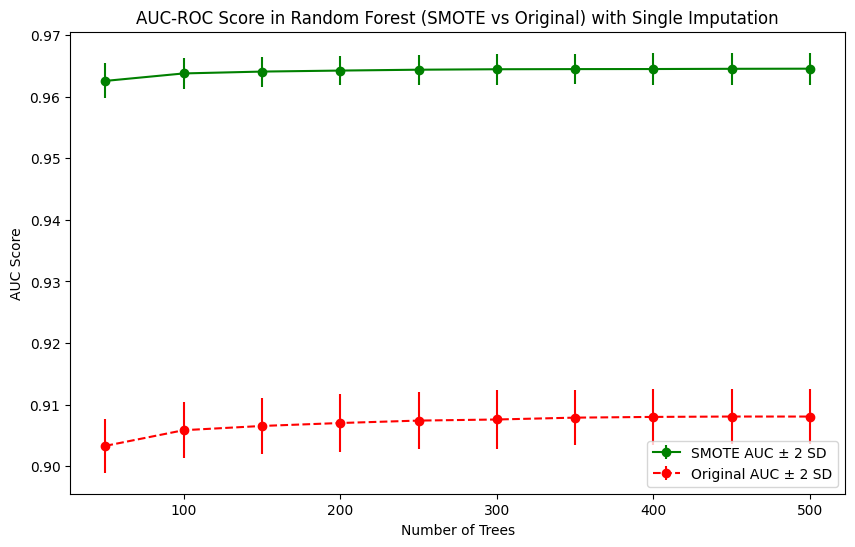

In [6]:
# WARNING: THIS TAKES AROUND 30 MINUTES TO RUN. AROUND 15 MINUTES FOR SMOTE AND 10 MINUTES FOR NON SMOTE. ###

# Perform single imputation to handle missing data using SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# Impute the datasets
X_train_smote_imputed = pd.DataFrame(imputer.fit_transform(X_train_smote_encoded), columns=X_train_smote_encoded.columns)
X_train_original_imputed = pd.DataFrame(imputer.fit_transform(X_train_original_encoded), columns=X_train_original_encoded.columns)

# Number of iterations for train-test splitting
n_iterations = 5

# Range of n_estimators to try
n_estimators_range = range(50, 501, 50)

# Pickle file path to save/load AUC results
auc_pickle_file = "auc_results_single_imputation.pkl"

# Function to fit Random Forest and collect AUC scores with train-test split
def calculate_auc_with_splits(X, y, n_iterations, n_estimators_range):
    auc_scores_list = []

    for i in tqdm(range(n_iterations), desc="Calculating AUC over splits"):
        # Split data into 80% train, 20% test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

        auc_scores_per_iteration = []

        for n in n_estimators_range:
            rf_model = RandomForestClassifier(n_estimators=n, random_state=42)
            rf_model.fit(X_train, y_train.values.ravel())

            # Predict probabilities on the test set
            y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

            # Calculate AUC-ROC score
            auc_score = roc_auc_score(y_test, y_pred_proba)
            auc_scores_per_iteration.append(auc_score)

        auc_scores_list.append(auc_scores_per_iteration)

    # Convert list of lists to numpy array for easier mean and std calculation
    auc_scores_array = np.array(auc_scores_list)
    
    # Calculate mean and standard deviation across iterations
    auc_means = auc_scores_array.mean(axis=0)
    auc_stds = auc_scores_array.std(axis=0)
    
    return auc_means, auc_stds

# Check if the pickle file exists to avoid re-computation
if os.path.exists(auc_pickle_file):
    # Load AUC results from pickle file if it exists
    with open(auc_pickle_file, "rb") as f:
        auc_means_smote, auc_stds_smote, auc_means_original, auc_stds_original = pickle.load(f)
    print("Loaded AUC results from pickle file.")
else:
    # Calculate AUC scores for SMOTE and original datasets over 5 iterations
    auc_means_smote, auc_stds_smote = calculate_auc_with_splits(X_train_smote_imputed, y_train_smote, n_iterations, n_estimators_range)
    auc_means_original, auc_stds_original = calculate_auc_with_splits(X_train_original_imputed, y_train_original, n_iterations, n_estimators_range)

    # Save the AUC results to a pickle file
    with open(auc_pickle_file, "wb") as f:
        pickle.dump((auc_means_smote, auc_stds_smote, auc_means_original, auc_stds_original), f)
    print("Saved AUC results to pickle file.")

# Plotting the AUC scores with mean +/- 2 standard deviations

# Plot AUC scores for SMOTE data
plt.figure(figsize=(10, 6))
plt.errorbar(n_estimators_range, auc_means_smote, yerr=2*auc_stds_smote, marker='o', linestyle='-', color='green', label='SMOTE AUC ± 2 SD')
plt.errorbar(n_estimators_range, auc_means_original, yerr=2*auc_stds_original, marker='o', linestyle='--', color='red', label='Original AUC ± 2 SD')
plt.xlabel('Number of Trees')
plt.ylabel('AUC Score')
plt.title('AUC-ROC Score in Random Forest (SMOTE vs Original) with Single Imputation')
plt.legend()
plt.grid(False)
plt.show()


We obtain a similar conclusion and we see that the trees trained on the SMOTE dataset perform better according to the mean AUC. Having seen that SMOTE indeed helps improving the performance of a classifier for imbalanced data, we henceforth only use the SMOTE dataset.

**Note**: There is a more sophisticated way to perform imputation, called **multiple imputation**. Multiple imputation (MI) is a method for dealing with missing data by filling in the gaps multiple times, creating several “complete” datasets. Each of these datasets is analyzed separately, and the results are combined to account for the uncertainty in the missing values. A common approach to MI is the Multiple Imputation by Chained Equations (MICE), which is versatile and applicable in various contexts. This technique generates multiple predictions for each missing value, allowing the analysis of the imputed data to reflect the uncertainty inherent in these estimates. 

We direct the reader to [1] for further details. Due to computational limitations, we will not be using MICE here, and will only do single imputation. 

## 2.3. Optimisation using Random Grid Search with CV

We will do single imputation using mode imputation and do a randomised grid search using cross-validation (CV) to find the optimal parameters for the random forest. There are many parameters that can be optimised for the random forest and it was computationally infeasible to do a fine grid search. We attempted to search over 72 combinations, but this would require too much compute as using 5-fold CV would lead to 360 fits. To remedy this, we searched over 10 combinations of parameters using 5-fold CV, resulting in 50 fits. 

In [7]:
# Perform single imputation to handle missing data
imputer = SimpleImputer(strategy='most_frequent')
X_train_smote_imputed = pd.DataFrame(imputer.fit_transform(X_train_smote_encoded), columns=X_train_smote_encoded.columns)

# Define the RandomForest model with a fixed number of estimators
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)

# Define the hyperparameter grid to search (same as before)
param_grid = {
    'max_features': [2, 4, 6, 8, 10, 12],  # Number of features to consider at each split
    'max_depth': [10, 20, 30, None],       # Limit the maximum depth of the trees
    'min_samples_split': [2, 5, 10]        # Minimum samples required to split an internal node
}

# Setup the RandomizedSearchCV (set n_iter to control how many combinations to try)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   n_iter=10, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Pickle file path to save/load results
pickle_file = "rf_random_search_results.pkl"

# Check if the pickle file exists to avoid re-running random search
if os.path.exists(pickle_file):
    with open(pickle_file, "rb") as f:
        best_params = pickle.load(f)
    print("Loaded best parameters from pickle file.")
else:
    # Perform the random search
    random_search.fit(X_train_smote_imputed, y_train_smote.values.ravel())
    
    # Get the best parameters from the random search
    best_params = random_search.best_params_
    print(f"Best parameters from random search: {best_params}")
    
    # Save the best parameters to a pickle file
    with open(pickle_file, "wb") as f:
        pickle.dump(best_params, f)
    print("Saved best parameters to pickle file.")

# Output the best parameters
print("Best parameters found from the random search:")
print(best_params)

Loaded best parameters from pickle file.
Best parameters found from the random search:
{'min_samples_split': 2, 'max_features': 2, 'max_depth': None}


We find 
> {'min_samples_split': 2, 'max_features': 2, 'max_depth': None}.

If more computing power was available, we could do a more refined search. We however proceed with these values, together with a number of trees equal to 300 that we found earlier.

# 3. Fitting the Random Forest

We fit the random forest with the hyperparameters found using random search.

In [8]:
# Load best parameters from the pickle file
pickle_file = "rf_random_search_results.pkl"
with open(pickle_file, "rb") as f:
    best_params_ = pickle.load(f)

# Fix n_estimators to 300 and use the rest of the best parameters
best_params_['n_estimators'] = 300

# Convert the target variable in the test set to numeric (0 and 1)
y_test = pd.read_csv("../data/y_test.csv", index_col=0)
y_test_numeric = y_test.replace({'<=50K': 0, '>50K': 1}).astype(int)

# Instantiate the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(**best_params_, random_state=42)

# Fit the model on the SMOTE training dataset
best_rf_model.fit(X_train_smote_imputed, y_train_smote.values.ravel())

C:\Users\megar\AppData\Local\Temp\ipykernel_30324\2778708260.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_numeric = y_test.replace({'<=50K': 0, '>50K': 1}).astype(int)


RandomForestClassifier(max_features=2, n_estimators=300, random_state=42)

## 3.1 Evaluating the Performance 

We look at the precision, recall and ROC curve.

Accuracy on test set:  0.8039258932509925
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.93      0.80      0.86      6862
        >50K       0.57      0.81      0.67      2206

    accuracy                           0.80      9068
   macro avg       0.75      0.80      0.76      9068
weighted avg       0.84      0.80      0.81      9068



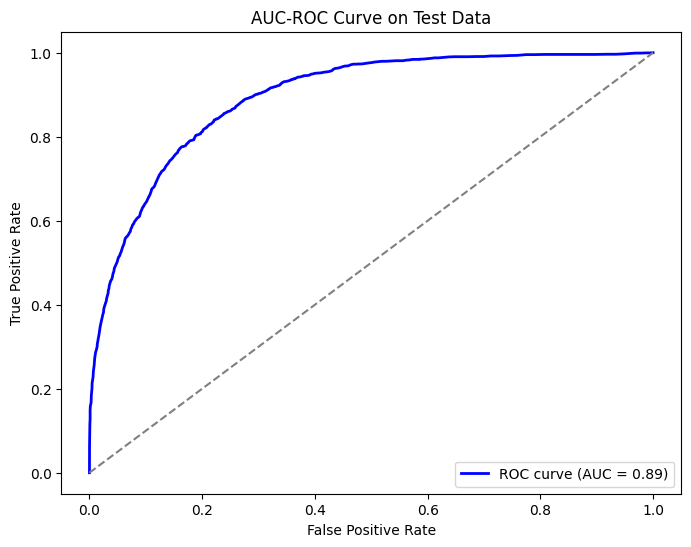

ROC data saved to roc_data.pkl.


In [9]:
# Predict probabilities for AUC curve on the test dataset
y_pred = best_rf_model.predict(X_test_encoded)
y_pred_proba = best_rf_model.predict_proba(X_test_encoded)[:, 1]

# Evaluate the model
print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate AUC-ROC score on the test dataset
auc_score = roc_auc_score(y_test_numeric, y_pred_proba)

# Plot AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve on Test Data')
plt.legend(loc='lower right')
plt.show()

# Save fpr and tpr to a pickle file
roc_data = {
    'fpr': fpr,
    'tpr': tpr,
    'auc': roc_auc  # Optional: Save AUC score if needed
}

with open('roc_data.pkl', 'wb') as f:
    pickle.dump(roc_data, f)

print("ROC data saved to roc_data.pkl.")

The precision for high income individuals is low, and the accuracy is around 80%. This was worse than expected performance. We look at the ROC curve next. The AUC is not much better than we saw for single trees! 

## 3.2 Predictions by Sex
We now look at the predictions by sex to investigate our chosen question of finding out how the proportion of high income individuals varies by income.

results_df saved to results_df.pkl.


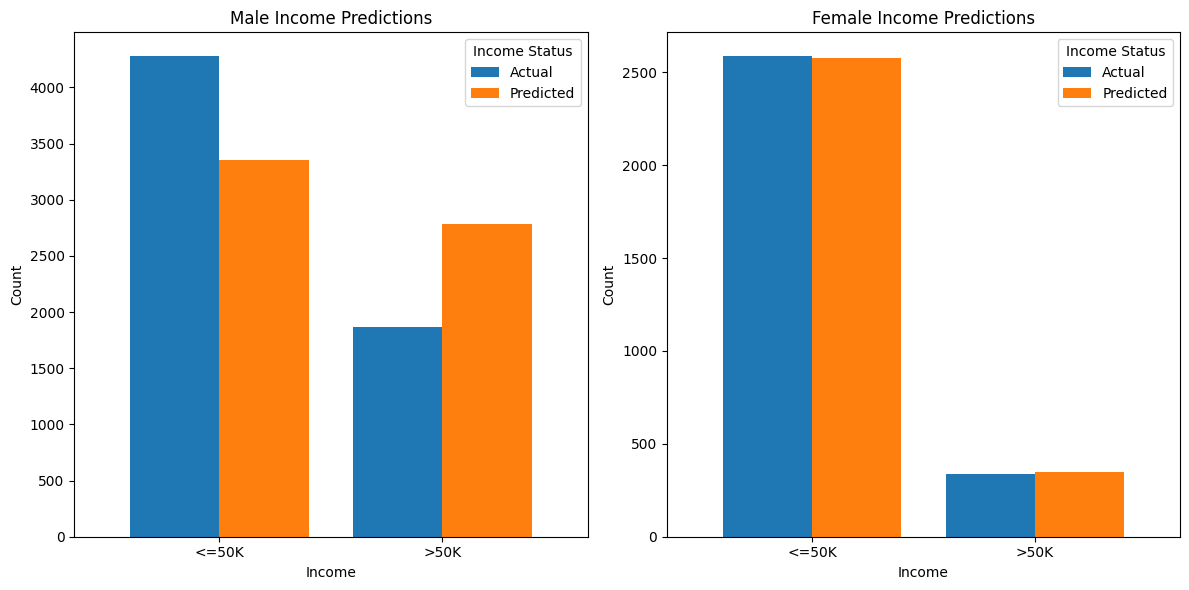

In [10]:
# Create a DataFrame for easier plotting of actual vs predicted income by sex
results_df = pd.DataFrame({
    'Predicted Income': y_pred,
    'Actual Income': y_test.values.ravel(),
    'Sex': X_test["sex"]
})

# Save results_df to a pickle file
with open('results_df.pkl', 'wb') as f:
    pickle.dump(results_df, f)

print("results_df saved to results_df.pkl.")

# Filter for males and females
male_df = results_df[results_df['Sex'] == 'Male']
female_df = results_df[results_df['Sex'] == 'Female']

# Count occurrences for males
male_actual_counts = male_df['Actual Income'].value_counts()
male_predicted_counts = male_df['Predicted Income'].value_counts()

# Count occurrences for females
female_actual_counts = female_df['Actual Income'].value_counts()
female_predicted_counts = female_df['Predicted Income'].value_counts()

# Create a DataFrame to hold counts for males
male_income_counts = pd.DataFrame({
    'Actual': male_actual_counts,
    'Predicted': male_predicted_counts
}).fillna(0)

# Create a DataFrame to hold counts for females
female_income_counts = pd.DataFrame({
    'Actual': female_actual_counts,
    'Predicted': female_predicted_counts
}).fillna(0)

# Create side-by-side bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Male plot
male_income_counts.plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e'], width=0.8)
axes[0].set_title('Male Income Predictions')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Income')
axes[0].set_xticklabels(male_income_counts.index, rotation=0)
axes[0].legend(title='Income Status', loc='upper right')

# Female plot
female_income_counts.plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e'], width=0.8)
axes[1].set_title('Female Income Predictions')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Income')
axes[1].set_xticklabels(female_income_counts.index, rotation=0)
axes[1].legend(title='Income Status', loc='upper right')

plt.tight_layout()
plt.show()


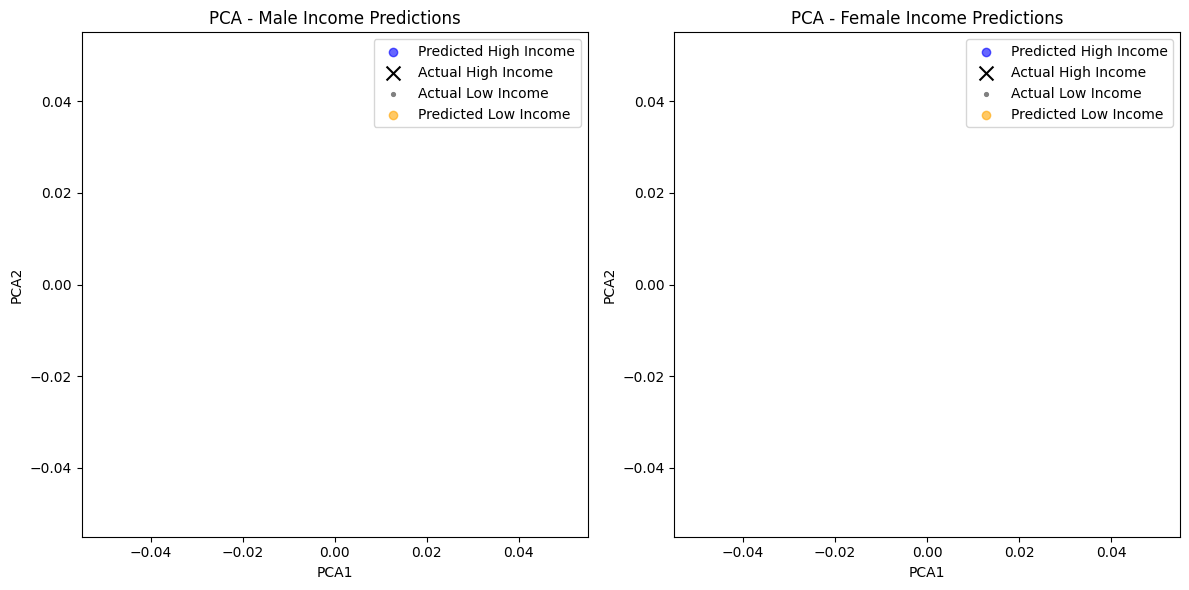

In [31]:
# Attempt to produce PCA visualisation (didn't work)

# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# import pickle

# # Load the results_df from pickle (assuming it's already saved)
# with open('results_df.pkl', 'rb') as f:
#     results_df = pickle.load(f)

# # Drop the 'sex' column from X_test for encoding purposes
# X_test_features = X_test.drop(columns=['sex'])

# # Identify categorical columns in X_test_features
# categorical_cols = X_test_features.select_dtypes(include=['object', 'category']).columns

# # Apply one-hot encoding to categorical columns
# column_transformer = ColumnTransformer(
#     transformers=[('cat', OneHotEncoder(drop='first', sparse_output=True), categorical_cols)],
#     remainder='passthrough'
# )

# # Transform the features
# X_test_encoded = column_transformer.fit_transform(X_test_features)

# # Apply StandardScaler with with_mean=False to handle sparse matrix
# scaler = StandardScaler(with_mean=False)  # Prevent centering sparse matrices
# X_test_scaled = scaler.fit_transform(X_test_encoded)

# # Perform PCA (2 components for visualization)
# pca = PCA(n_components=2)
# X_test_pca = pca.fit_transform(X_test_scaled)

# # Add PCA components to results_df
# results_df['PCA1'] = X_test_pca[:, 0]
# results_df['PCA2'] = X_test_pca[:, 1]

# # Ensure the predicted income is available in results_df
# # Assuming y_pred is available (predictions from the model)
# results_df['Predicted Income'] = y_pred  # Assuming y_pred is defined
# results_df['Actual Income'] = results_df['Actual Income'].values  # Make sure actual income is present

# # Separate data for males and females
# male_df = results_df[results_df['Sex'] == 'Male']
# female_df = results_df[results_df['Sex'] == 'Female']

# # Plot PCA results
# plt.figure(figsize=(12, 6))

# # Male Plot
# plt.subplot(1, 2, 1)
# # High Income Predictions
# plt.scatter(male_df[male_df['Predicted Income'] == 1]['PCA1'], 
#             male_df[male_df['Predicted Income'] == 1]['PCA2'], 
#             c='blue', label='Predicted High Income', alpha=0.6)
# # Actual High Income
# plt.scatter(male_df[male_df['Actual Income'] == 1]['PCA1'], 
#             male_df[male_df['Actual Income'] == 1]['PCA2'], 
#             c='black', label='Actual High Income', marker='x', s=100)
# # Actual Low Income
# plt.scatter(male_df[male_df['Actual Income'] == 0]['PCA1'], 
#             male_df[male_df['Actual Income'] == 0]['PCA2'], 
#             c='gray', label='Actual Low Income', marker='.', s=30)
# # Low Income Predictions
# plt.scatter(male_df[male_df['Predicted Income'] == 0]['PCA1'], 
#             male_df[male_df['Predicted Income'] == 0]['PCA2'], 
#             c='orange', label='Predicted Low Income', alpha=0.6)

# plt.title('PCA - Male Income Predictions')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
# plt.legend()

# # Female Plot
# plt.subplot(1, 2, 2)
# # High Income Predictions
# plt.scatter(female_df[female_df['Predicted Income'] == 1]['PCA1'], 
#             female_df[female_df['Predicted Income'] == 1]['PCA2'], 
#             c='blue', label='Predicted High Income', alpha=0.6)
# # Actual High Income
# plt.scatter(female_df[female_df['Actual Income'] == 1]['PCA1'], 
#             female_df[female_df['Actual Income'] == 1]['PCA2'], 
#             c='black', label='Actual High Income', marker='x', s=100)
# # Actual Low Income
# plt.scatter(female_df[female_df['Actual Income'] == 0]['PCA1'], 
#             female_df[female_df['Actual Income'] == 0]['PCA2'], 
#             c='gray', label='Actual Low Income', marker='.', s=30)
# # Low Income Predictions
# plt.scatter(female_df[female_df['Predicted Income'] == 0]['PCA1'], 
#             female_df[female_df['Predicted Income'] == 0]['PCA2'], 
#             c='orange', label='Predicted Low Income', alpha=0.6)

# plt.title('PCA - Female Income Predictions')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
# plt.legend()

# plt.tight_layout()
# plt.show()


The female predictions are surprisingly good, despite the fact that there were much fewer females in the dataset. For males, there is a tendency to predict them to be high-income, leading to a disparity between actual and predicted counts.

# 4. Conclusion

We have used random forests, a state of the art classifier, to do income predictions. We tuned the number of trees first, since Breiman states that random forests do not overfit, having an error that stabilises as the number of trees increases. We then used randomised grid search to optimise over the remaining parameters. 

The result was that we obtained great predictions for females, but predictions for males left room for improvement. In particular, low-income males had a tendency to be predicted as high-income, which led to poor performance in that area.

To extend this analysis, it would be useful to consider using a finer grid search, and using exhaustive search rather than randomised search. It would also be helpful to consider feature engineering and creating other features to enrich the model.


# 5. References

[1] Van Buuren, Stef, and Karin Groothuis-Oudshoorn. "mice: Multivariate imputation by chained equations in R." Journal of statistical software 45 (2011): 1-67.
[2] Breiman, Leo. "Random forests." Machine learning 45 (2001): 5-32.
